In [ ]:
import numpy as np

import uproot
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import torch
from torch import optim
from torch.utils.data import DataLoader

import typing

import anomalydetector
from anomalydetector.models.VAE import NFVAE, VAE
from anomalydetector.models.utils import get_latent_dists
from anomalydetector.models.NICE import NICEModel
from anomalydetector.processing import InMemoryND280EventDataset, nd280EventDataset
from anomalydetector.plotting import make_corner_plot


if torch.cuda.is_available():
    print("Found cuda device, will use GPU")
else:
    print("No GPU :(")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Found cuda device, will use GPU


In [2]:
with uproot.open('/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run2air_v1.root') as file:

    sample_sum = file['sample_sum'].arrays(
        filter_branch=lambda b: b.name.find("Graph") == -1 and b.typename.find("std::vector") == -1,
        library='pd'
    )

    print (":::::: Available branches ::::::::")

    for branch in file['sample_sum'].branches:
        print(f'  - {branch.name}: {branch.typename}')


:::::: Available branches ::::::::
  - NVertexID: int32_t
  - MAX_VERTEX: int32_t
  - VertexID: int32_t[]
  - NSamples: int32_t
  - SelectedSample: int32_t
  - Run: int32_t
  - RunNumber: int32_t
  - SubRunNumber: int32_t
  - EventNumber: int32_t
  - DetNomWeight: double
  - NeutrinoCode: int32_t[]
  - Enu: double[]
  - TrueNeutrinoDirX: double
  - TrueNeutrinoDirY: double
  - TrueNeutrinoDirZ: double
  - TrueLepPDG: int32_t
  - TruePmu: double[]
  - TrueLepDirX: double
  - TrueLepDirY: double
  - TrueLepDirZ: double
  - TrueCosThetamu: double[]
  - Pmu: double[]
  - RecoLepDirX: double
  - RecoLepDirY: double
  - RecoLepDirZ: double[]
  - CosThetamu: double[]
  - TruePostFSIPiPDG: int32_t
  - TruePostFSIPiMom: double
  - TruePostFSIPiDirX: double
  - TruePostFSIPiDirY: double
  - TruePostFSIPiDirZ: double
  - TruePreFSIPiPDG: int32_t
  - TruePreFSIPiMom: double
  - TruePreFSIPiDirX: double
  - TruePreFSIPiDirY: double
  - TruePreFSIPiDirZ: double
  - RecoPiMom: double
  - RecoPiDirX: 

In [3]:

train_ds = InMemoryND280EventDataset(
    #root="/home/hep/ewmiller/anomaly-detection/processed_files/MC/ID",
    filenames=[
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run2air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run2water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run3air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run4air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run4water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run5water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run6air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run7water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run8air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run8water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run9water_v1.root'
    ],
    branches=["Pmu", "RecoLepDirX", "RecoLepDirY", "RecoLepDirZ", "RecoProtonMom", "RecoProtonDirX", "RecoProtonDirY", "RecoProtonDirZ"],
    branch_scaling=np.array([0.2e-3, 1.0, 1.0, 1.0, 0.2e-3, 1.0, 1.0, 1.0], dtype=np.float32),
    branch_mask_vals=np.array([-999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0]),
    branch_mask_replace_vals=np.array([0.0, -2.0, -2.0, -2.0, 0.0, -2.0, -2.0, -2.0], dtype=np.float32),
    filter="(isSRC!=1) & (RecoProtonMom!=-999.0)" #"q0<2000.0"
)

ood_ds = InMemoryND280EventDataset(
    #root="/home/hep/ewmiller/anomaly-detection/processed_files/MC/OOD",
    filenames=[
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run2air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run2water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run3air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run4air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run4water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run5water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run6air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run7water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run8air_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run8water_v1.root',
        '/vols/t2k/nd280-OA2022/FDS-inputs/FDS_run9water_v1.root'
    ],
    branches=["Pmu", "RecoLepDirX", "RecoLepDirY", "RecoLepDirZ", "RecoProtonMom", "RecoProtonDirX", "RecoProtonDirY", "RecoProtonDirZ"],
    branch_scaling=np.array([0.2e-3, 1.0, 1.0, 1.0, 0.2e-3, 1.0, 1.0, 1.0], dtype=np.float32),
    branch_mask_vals=np.array([-999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0]),
    branch_mask_replace_vals=np.array([0.0, -2.0, -2.0, -2.0, 0.0, -2.0, -2.0, -2.0], dtype=np.float32),
    filter="(isSRC==1) & (RecoProtonMom!=-999.0)" #"q0>= 2000.0"
)

train_ds.process()
ood_ds.process()


In [4]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of OOD examples:      {len(ood_ds)}')


raw_dist = np.ndarray((1, train_ds.get_n_features()))
ood_dist = np.ndarray((1, ood_ds.get_n_features()))

print()
print("##### Making ID and OOD raw distributions ######")

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True)
progressbar = tqdm(enumerate(train_loader), total=len(train_loader)-1)
for batch_n, (x, n) in progressbar:
    raw_dist = np.concatenate((raw_dist, x), axis=0)
    progressbar.update()

ood_loader = DataLoader(ood_ds, batch_size=4096, shuffle=True)
progressbar = tqdm(enumerate(ood_loader), total=len(ood_loader)-1)
for batch_n, (x, n) in progressbar:
    ood_dist = np.concatenate((ood_dist, x), axis=0)
    progressbar.update()


Number of training examples: 611578
Number of OOD examples:      13182

##### Making ID and OOD raw distributions ######


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

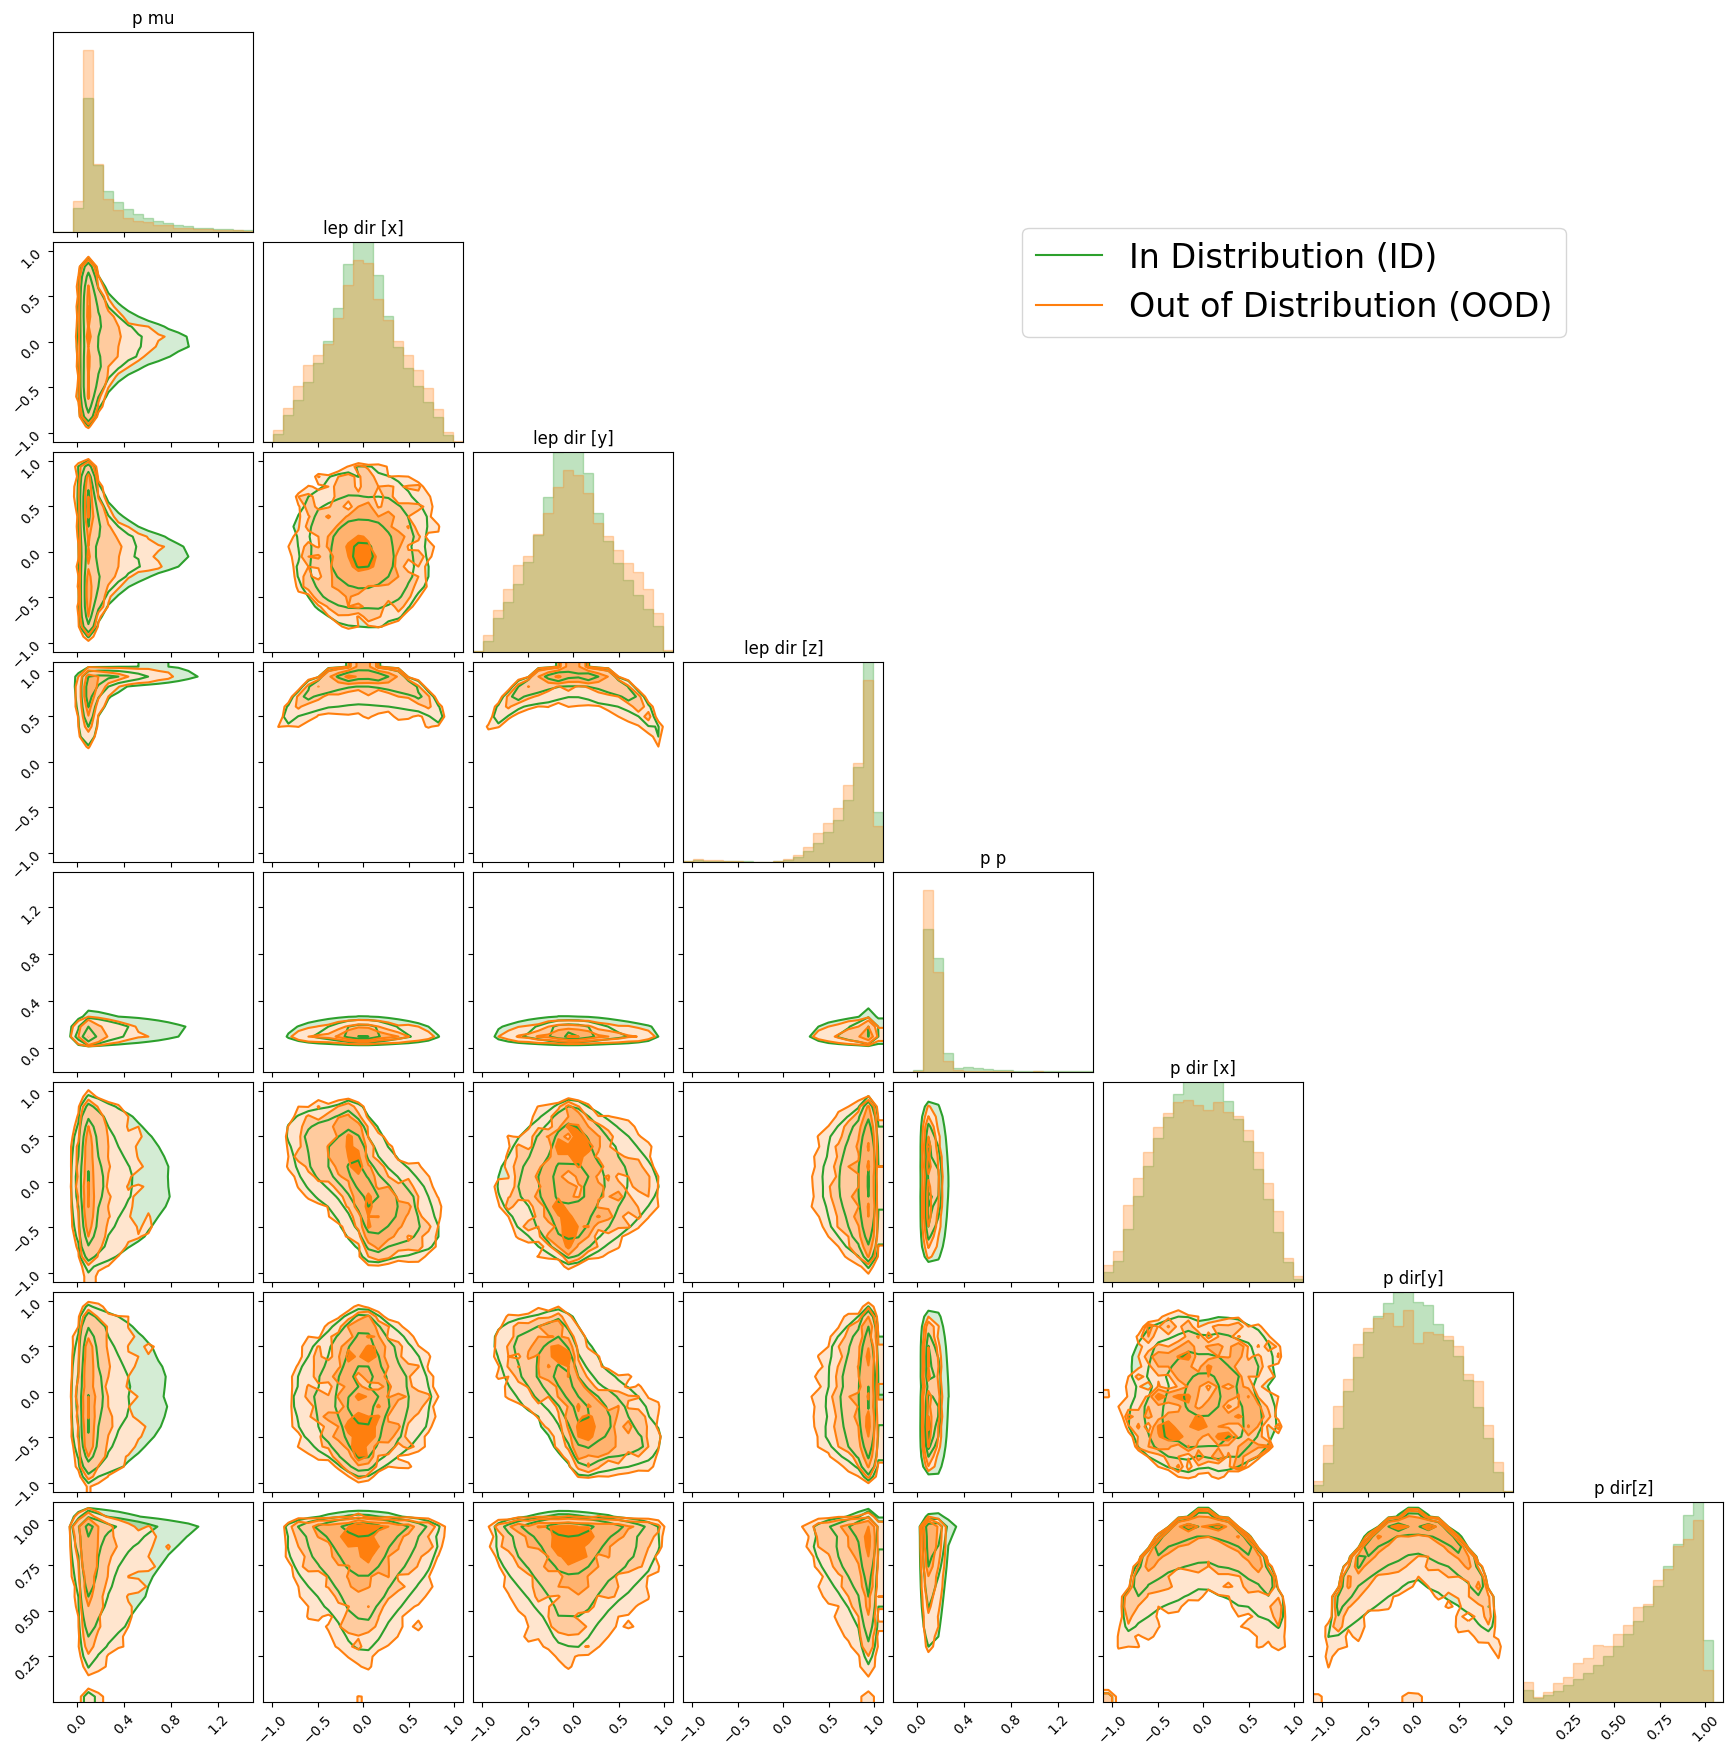

In [ ]:
make_corner_plot(raw_dist, ood_dist, 
    ranges = [(-0.2, 1.5), (-1.1,1.1),    (-1.1,1.1),    (-1.1,1.1),    (-0.2, 1.5), (-1.1,1.1),  (-1.1, 1.1), (0.0, 1.1)],
    titles = ["p mu",      "lep dir [x]", "lep dir [y]", "lep dir [z]", "p p",       "p dir [x]", "p dir[y]",  "p dir[z]"],
).show()

In [6]:
n_features = train_ds.get_n_features()

######################
## set up model ##
######################

# model = VAE(6, 2) 

# model = NFVAE(
#     n_bottleneck = 2,
#     hidden_units_encoder = [n_features, 8, 4, n_bottleneck*2],
#     hidden_units_decoder = [n_bottleneck, 4, 8, n_features],
#     n_flows = 0,
#     flow_type = "Planar",
#     device = device,
# )

model = NICEModel(n_features, 5, [64, 128, 256, 128, 64])

model.to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

model.compile()
model.train()

print("##### Model #####'")
for module in model.modules():
    print(module)

print(f"trainable parameters: {params}")

/home/hep/ewmiller/anomaly-detection/env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


##### Model #####'
NICEModel(
  (gauss_loss): GaussianPriorNICELoss()
  (flows): Sequential(
    (0): AdditiveCouplingLayer(
      (nonlinearity): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(in_features=128, out_features=256, bias=True)
        (5): ReLU(inplace=True)
        (6): Linear(in_features=256, out_features=128, bias=True)
        (7): ReLU(inplace=True)
        (8): Linear(in_features=128, out_features=64, bias=True)
        (9): ReLU(inplace=True)
        (10): Linear(in_features=64, out_features=4, bias=True)
      )
    )
    (1): AdditiveCouplingLayer(
      (nonlinearity): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): ReLU(inplace=True)
        (4): Linear(

In [ ]:
n_epochs = 300

train_loader:DataLoader = DataLoader(train_ds, batch_size=100000, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epoch_progressbar = tqdm(range(n_epochs), total = n_epochs, desc="epoch")
for epoch_n in epoch_progressbar: 
    
    epoch_loss = 0.0
    n_batches  = 0

    batch_progressbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_n, (x, n) in batch_progressbar:

        x = x.to(device)
        optimizer.zero_grad()
        loss = model.train_batch(x)
        optimizer.step()
        
        batch_progressbar.set_description(f"loss: {loss.item():.4f}")

        # update running mean loss
        epoch_loss += loss.item()
        n_batches += 1

    
    # make plot of the latent space
    id_encoded,  id_llh  = get_latent_dists(model, train_loader, device, quiet=True)
    ood_encoded, ood_llh = get_latent_dists(model, ood_loader,   device, quiet=True)

    fig = make_corner_plot(id_encoded, ood_encoded,
        ranges = [(-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5)],
        titles = None,
        n_bins = 40
    )

    fig.savefig(f"plots/latent_dist-epoch-{epoch_n:04}.png")
    fig.clear()
    plt.close(fig)
        
    epoch_loss /= n_batches    
    epoch_progressbar.set_description(f"epoch {epoch_n} loss: {epoch_loss:.4f}")

epoch:   0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

W1027 15:01:51.682206 13198 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/home/hep/ewmiller/anomaly-detection/env/lib64/python3.9/site-packages/torch/_inductor/lowering.py:1696: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "models/src_detector_5-layer-64_128_256_128_64.pt")

loading data:   0%|          | 0/2 [00:00<?, ?it/s]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

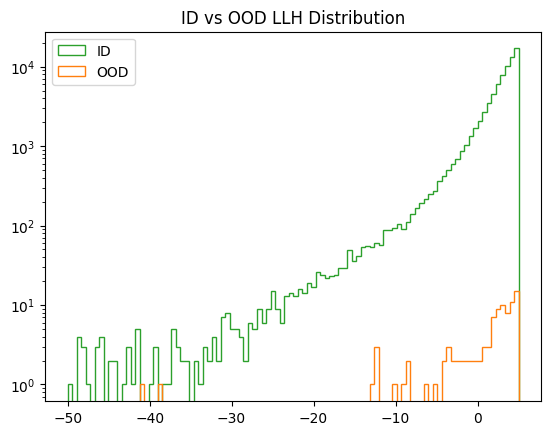

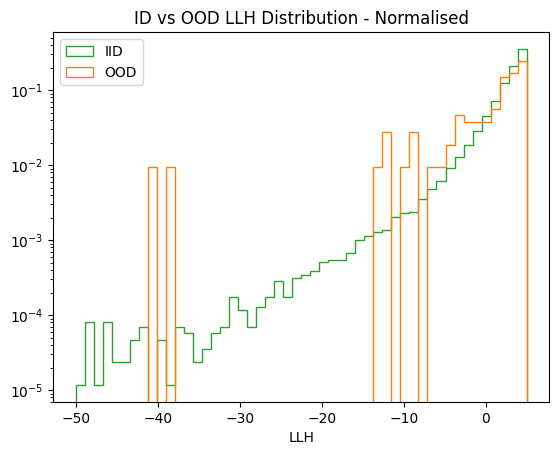

In [ ]:

id_encoded,  id_llh  = get_latent_dists(model, train_loader, device)
ood_encoded, ood_llh = get_latent_dists(model, ood_loader,   device)

plt.hist([ood_llh[:,0], id_llh[:,0],], color = ["tab:orange", "tab:green"], bins=100, range=(-50, 5), histtype="step", label=["OOD", "ID"], fill=False)
plt.title("ID vs OOD LLH Distribution")
plt.yscale('log')
plt.legend()
plt.show()

plt.hist([ood_llh[:,0], id_llh[:,0]], color = ["tab:orange", "tab:green"], bins=50, range=(-50, 5), histtype='step', label=["OOD", "IID"], density=True, fill=False)
plt.title("ID vs OOD LLH Distribution - Normalised")
plt.xlabel("LLH")
plt.yscale('log')
plt.legend()
plt.show()

LLH_CUT = 5.0
feat_names = ["p mu", "ctheta mu", "p pi", "ctheta pi", "p p", "ctheta p", "reco N pi", "reco N Prot"]
feat_ranges = [(0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0.001, 1), (-0.999,1), (0, 1.0), (0, 1.0)]
far_outliers = ood_llh[:, 0] < LLH_CUT


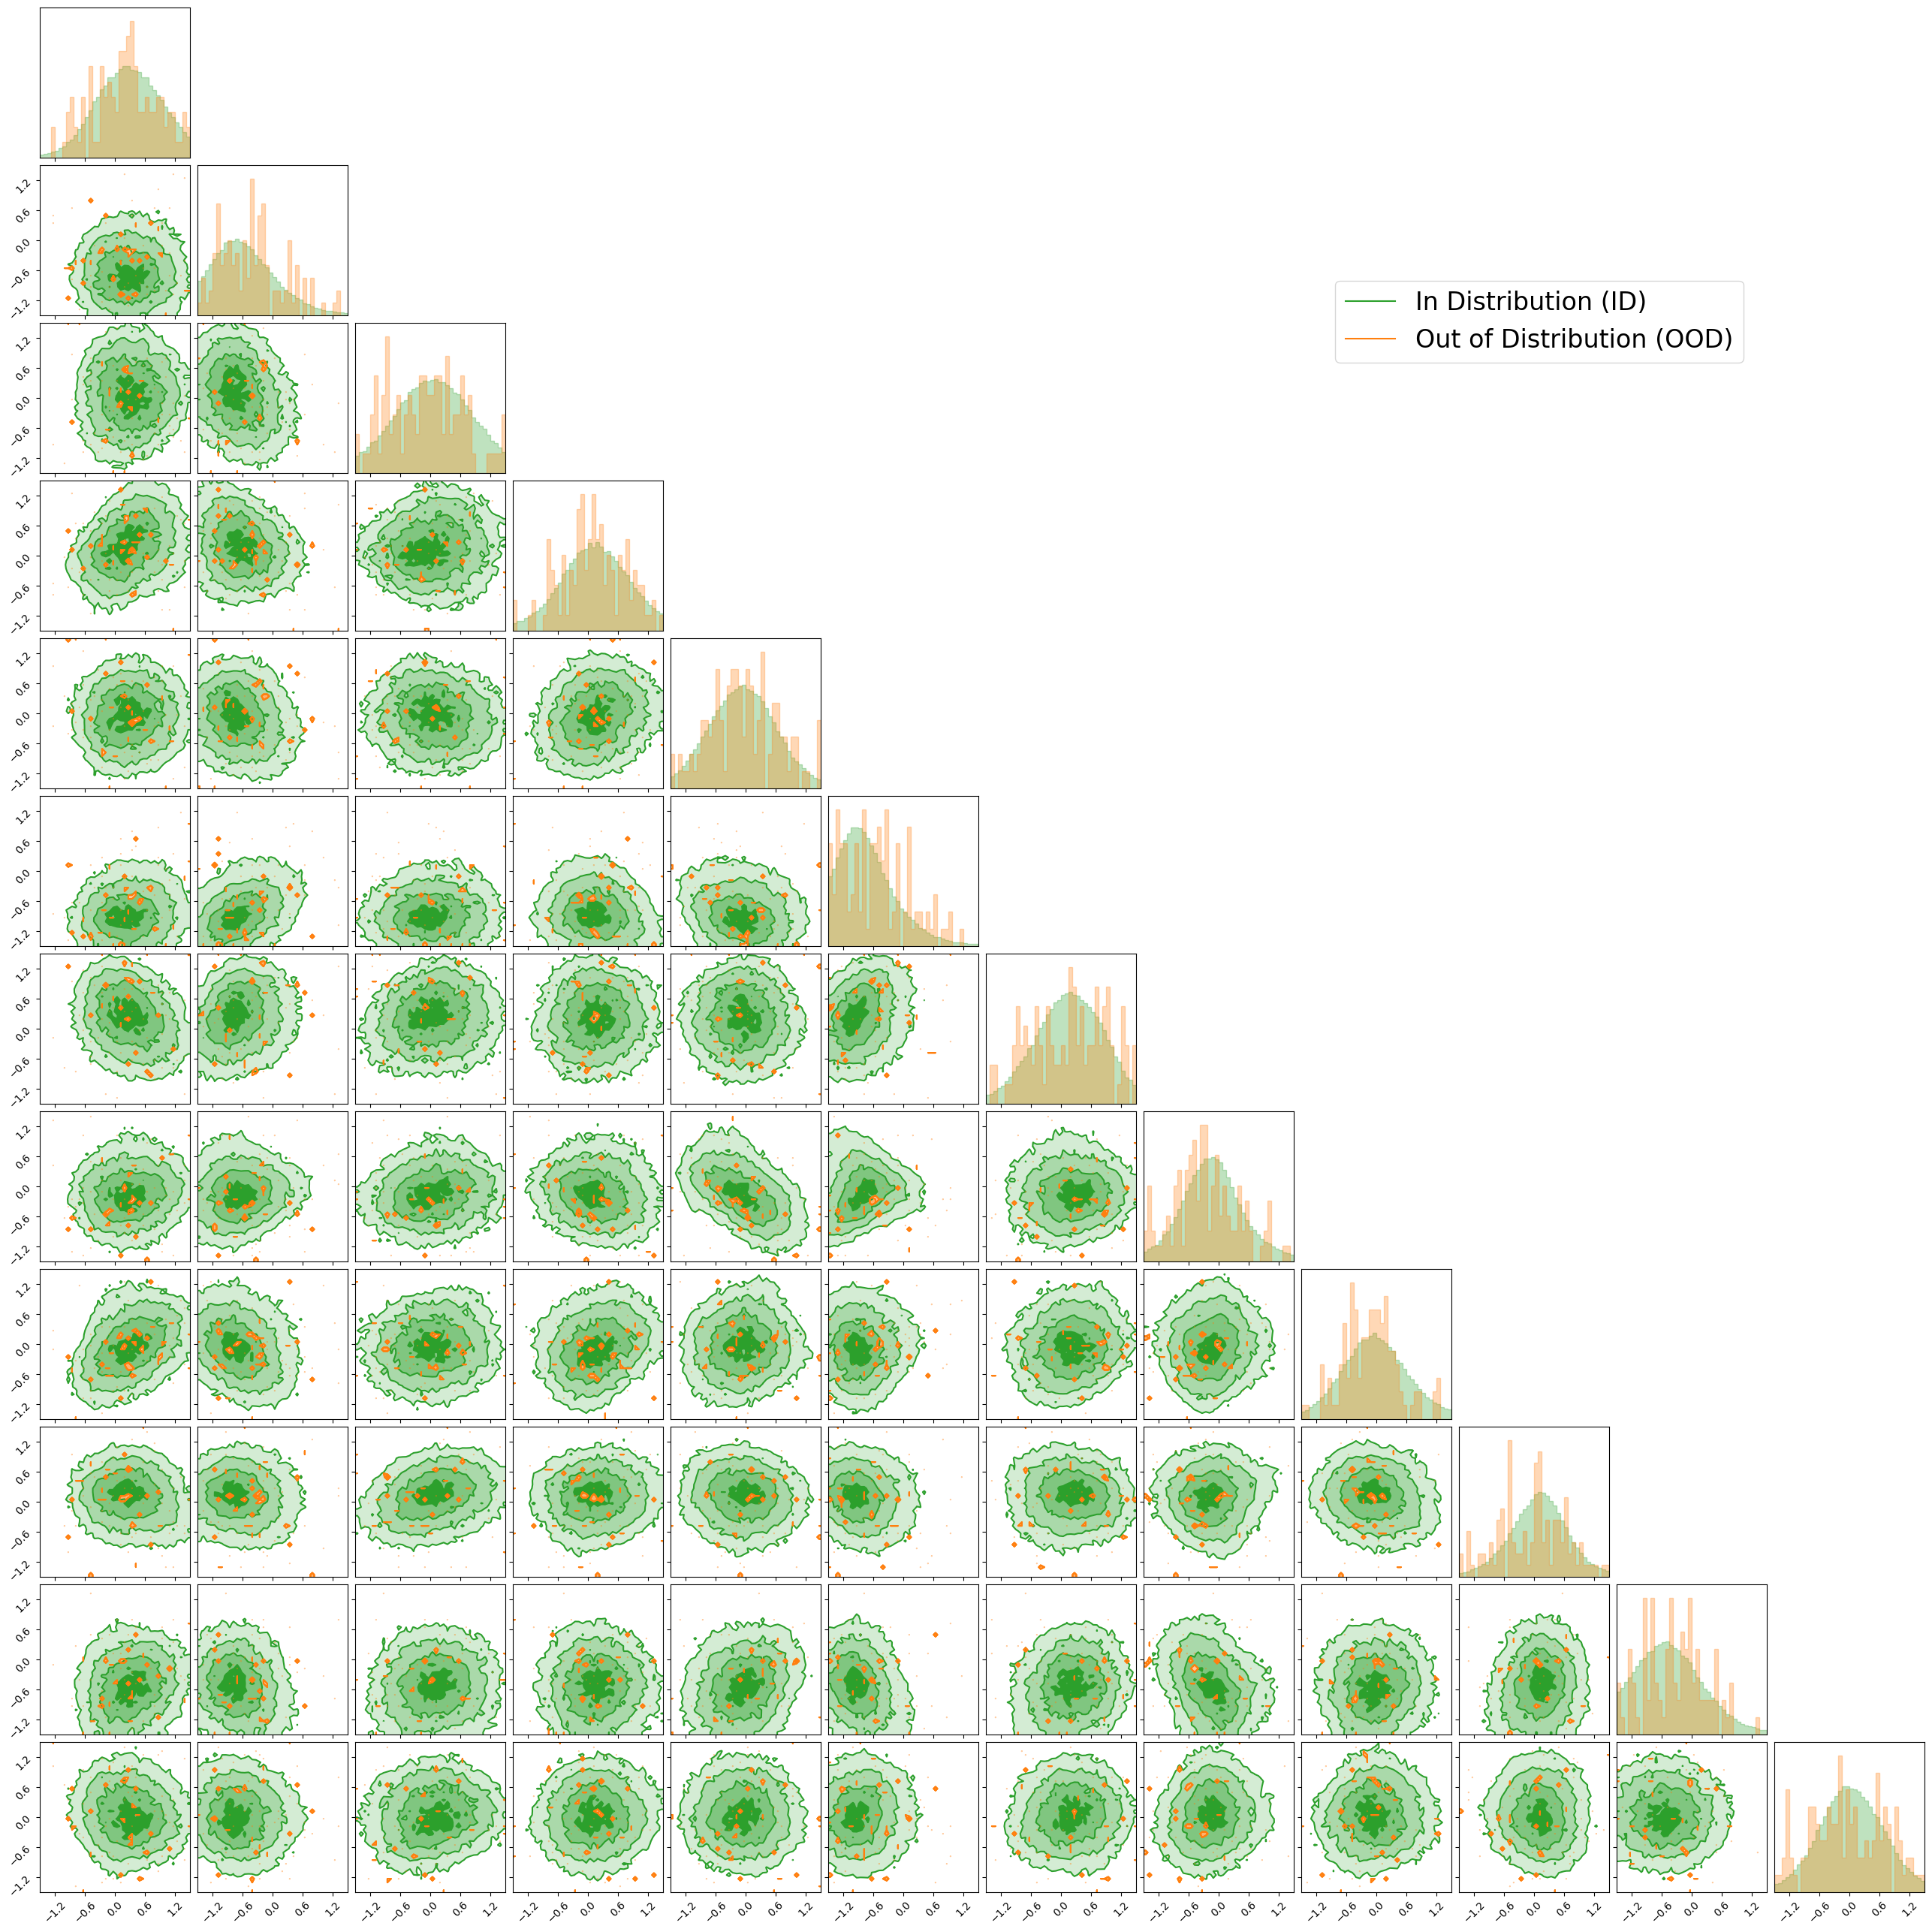

In [ ]:

make_corner_plot(id_encoded, ood_encoded,
    ranges = [(-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5), (-1.5, 1.5), (-1.5,1.5)],
    titles = None,
    n_bins = 40
).show()
